# Compare all 4 models

In [1]:
import utils
import matplotlib.pyplot as plt
import numpy as np
from model import Model
import torch
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC


In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
config = utils.read_config()
config['dir']['results'] = 'results_final'

In [8]:
# set seeds
utils.set_seeds(config['seed'])
behaviour_data_all, spikes, trial_indices = utils.load_dataset(config)
# consider data from only t = -1
# time_from = int(1/bin_len)
# behaviour_data_all, spikes = [x[time_from:, :] for x in behaviour_data_all], [x[time_from:, :] for x in spikes]
stim_idx, choice_idx, amp_idx, prev_choice_idx = 9, 3, 24, 6
stim = [x[0, stim_idx] for x in behaviour_data_all]
choice = [x[0, choice_idx] for x in behaviour_data_all]
# normalize amp by max value
num_contacts = [np.sum(x[:, 15:19], axis=1) for x in behaviour_data_all]
# concat them
behaviour_data = np.stack((stim, choice), axis=1)
# convert to torch tensors
behaviour_data = np.array(behaviour_data)
# behaviour_data = torch.tensor(behaviour_data, dtype=torch.float32)
spikes = np.array(spikes)
num_trials, time_bins, emissions_dim = spikes.shape
# create dataloader with random sampling for training and testing
# split data into training and testing
# behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.3, random_state=42)
behaviour_data_train, behaviour_data_test, spikes_train, spikes_test, num_contacts_train, num_contacts_test = train_test_split(behaviour_data, spikes, num_contacts, test_size=0.2, random_state=7)
# behaviour_data_train, behaviour_data_test, spikes_train, spikes_test, amp_train, amp_test = train_test_split(behaviour_data, spikes, amp, test_size=0.3, random_state=7)
# further split test into test and val
# behaviour_data_test, behaviour_data_val, spikes_test, spikes_val, amp_test, amp_val = train_test_split(behaviour_data_test, spikes_test, amp_test, test_size=0.5, random_state=7)
trials_train, trials_test = len(behaviour_data_train), len(behaviour_data_test)
# distribution of choice and stimulus in test
print("Train distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_train[:, 0]), np.mean(behaviour_data_train[:, 1])))
print("Test distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_test[:, 0]), np.mean(behaviour_data_test[:, 1])))
# print("Val distribution of Stimulus: {}, Choice: {}, Prev Choice: {}".format(np.mean(behaviour_data_val[:, 0]), np.mean(behaviour_data_val[:, 1]), np.mean(behaviour_data_val[:, 2])))
# labels
y_stim_train, y_stim_test = behaviour_data_train[:, 0], behaviour_data_test[:, 0]
y_choice_train, y_choice_test = behaviour_data_train[:, 1], behaviour_data_test[:, 1]

Train distribution of Stimulus: 0.46875, Choice: 0.359375
Test distribution of Stimulus: 0.5454545454545454, Choice: 0.48484848484848486


In [11]:
config['vae_gp']['monotonic']['use'] = False
config['decoder']['which'] = ''
config['vae_gp']['load_stage2'] = False
# model 1: no uni, no cnn
m1 = Model(config, input_dim=14)
m1.load_model('best')
# model 2: uni, no cnn
config['vae_gp']['monotonic']['use'] = True
config['decoder']['which'] = ''
m2 = Model(config, input_dim=14)
m2.load_model('best')
# model 3: no uni, cnn
config['vae_gp']['monotonic']['use'] = False
config['decoder']['which'] = 'cnn_indi'
m3 = Model(config, input_dim=14)
m3.load_model('best')
# model 4: uni, cnn
config['vae_gp']['monotonic']['use'] = True
config['decoder']['which'] = 'cnn_indi'
m4 = Model(config, input_dim=14)
m4.load_model('best')

Log det: tensor(-74.5478) Inverse max:  tensor(63.9476) Covariance max:  tensor(0.5100)
Number of trainable parameters in RNN: 2400
Number of trainable parameters in Posterior Mean X: 163
Number of trainable parameters in Posterior Mean Z: 163
Number of trainable parameters in Block Diagonal Z: 163
Number of trainable parameters in Cov X: 163
Number of trainable parameters in VAE: 3136
No behavior decoder
Loaded model
Log det: tensor(-74.5478) Inverse max:  tensor(63.9476) Covariance max:  tensor(0.5100)
Number of trainable parameters in RNN: 2400
Number of trainable parameters in Posterior Mean X: 163
Number of trainable parameters in Posterior Mean Z: 163
Number of trainable parameters in Block Diagonal Z: 163
Number of trainable parameters in Cov X: 163
Number of trainable parameters in VAE: 3299
No behavior decoder
Loaded model
Log det: tensor(-74.5478) Inverse max:  tensor(63.9476) Covariance max:  tensor(0.5100)
Number of trainable parameters in RNN: 2400
Number of trainable para

In [12]:
t = np.arange(-2, 0.5, 0.1)
colors = ['red', 'blue', 'green', 'black', 'yellow', 'pink']

def get_res(model):
    with torch.no_grad():
        model.eval()        
        # run on only test
        vae_output, _, amp_out_test = model.forward(torch.tensor(spikes_test, dtype=torch.float32), n_samples=1, use_mean_for_decoding=True)  
        y_recon_test, x_mu_test, z_mu_test, x_A_test, z_A_test, x_test, z_test, z_test_presoftmax, g_test = model.vae.extract_relevant(vae_output)
        # run only on train
        vae_output, _, amp_out_train = model.forward(torch.tensor(spikes_train, dtype=torch.float32), n_samples=1, use_mean_for_decoding=True)
        y_recon_train, x_mu_train, z_mu_train, x_A_train, z_A_train, x_train, z_train, z_train_presoftmax, g_train = model.vae.extract_relevant(vae_output)
        # # run only on val
        # vae_output, _, amp_out_val = model.forward(spikes_val, n_samples=1, use_mean_for_decoding=True)
        # y_recon_val, x_mu_val, z_mu_val, x_A_val, z_A_val, x_val, z_val, z_val_presoftmax, g_val = model.vae.extract_relevant(vae_output)
        # run on both
        vae_output, _, amp_out_all = model.forward(torch.tensor(spikes, dtype=torch.float32), n_samples=1, use_mean_for_decoding=True)
        y_recon_all, x_mu_all, z_mu_all, x_A_all, z_A_all, x_all, z_all, z_presoftmax_all, g_all = model.vae.extract_relevant(vae_output)
    return z_all, x_mu_all, z_train, x_mu_train, z_test, x_mu_test

def plot_z(z):
    z_std = np.std(z, axis=0)
    z_avg = np.mean(z, axis=0)
    # make x ticks of range 0.1 from -2 to 0.5
    bin_len = config['shape_dataset']['win_len']
    t = np.arange(-2, 0.5, bin_len)
    for i in range(z.shape[2]):
        plt.plot(t, z_avg[:, i], label='z{}'.format(i+1), color=colors[i])    
        plt.fill_between(t, z_avg[:, i]-z_std[:, i], z_avg[:, i]+z_std[:, i], alpha=0.3, color=colors[i])
    # plt.set_title('z')
    plt.legend()

In [13]:
# get all outputs
z_all_1, x_mu_all_1, z_train_1, x_mu_train_1, z_test_1, x_mu_test_1 = get_res(m1)
z_all_2, x_mu_all_2, z_train_2, x_mu_train_2, z_test_2, x_mu_test_2 = get_res(m2)
z_all_3, x_mu_all_3, z_train_3, x_mu_train_3, z_test_3, x_mu_test_3 = get_res(m3)
z_all_4, x_mu_all_4, z_train_4, x_mu_train_4, z_test_4, x_mu_test_4 = get_res(m4)

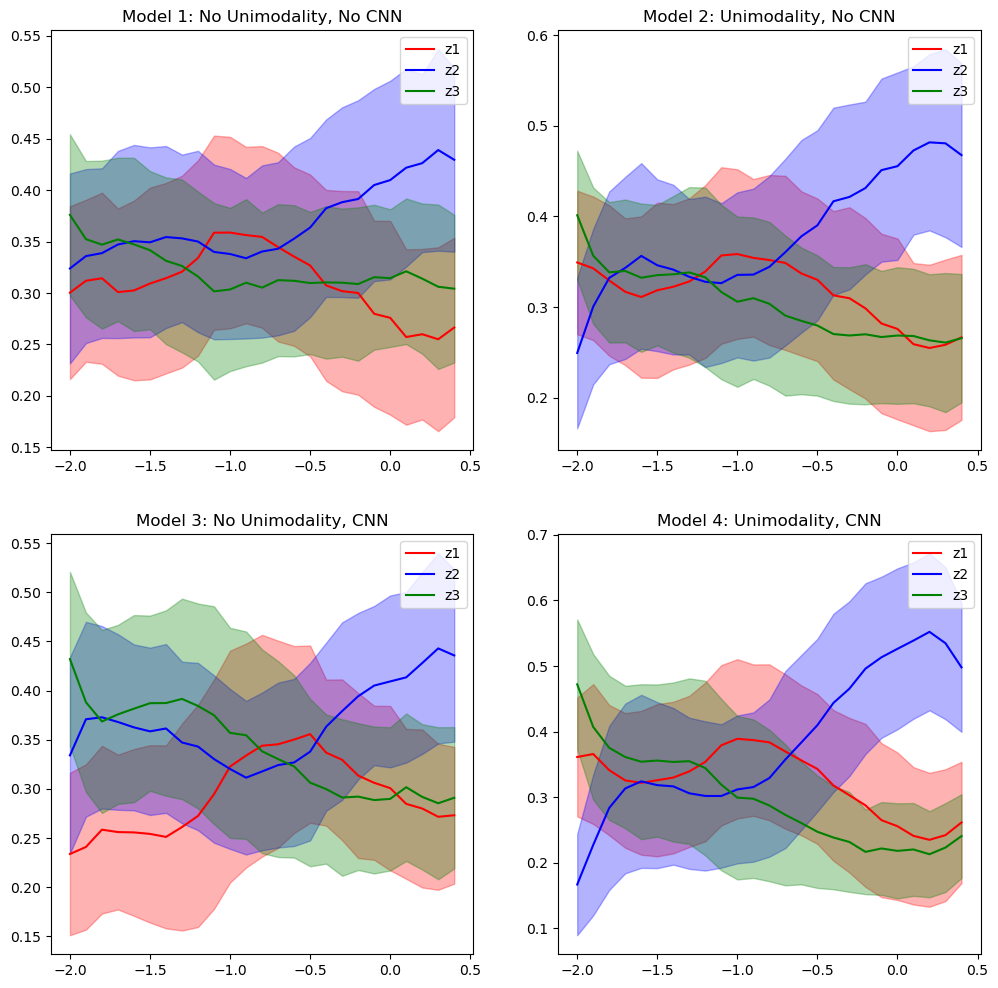

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plot_z(z_all_1)
plt.title('Model 1: No Unimodality, No CNN')
plt.subplot(2, 2, 2)
plot_z(z_all_2)
plt.title('Model 2: Unimodality, No CNN')
plt.subplot(2, 2, 3)
plot_z(z_all_3)
plt.title('Model 3: No Unimodality, CNN')
plt.subplot(2, 2, 4)
plot_z(z_all_4)
plt.title('Model 4: Unimodality, CNN')
plt.show()
plt.tight_layout()

In [15]:
def plot_x(model_id, x_data, behave_data, gs_obj, fig, ticks=False):
    def plot_cont_latent(data, label, axs, ax_id, linestyle):
        num_latents = data.shape[1]
        for i in range(num_latents):
            axs[ax_id].plot(t, data[:, i], label='{}_x{}'.format(label, i+1),
                            color=colors[i], linestyle=linestyle)        
    # group x for stimulus and choice
    stim, choice = behave_data[:, 0], behave_data[:, 1]
    # group x for stimulus
    num = 200
    x_stim_left, x_stim_right = x_data[stim == 1][:num].mean(axis=0), x_data[stim == 0][:num].mean(axis=0)
    x_choice_left, x_choice_right = x_data[choice == 1].mean(axis=0), x_data[choice == 0].mean(axis=0)
    # plot x for stimulus and choice    
    # title for gs_obj    
    gssub = gs_obj.subgridspec(2, 1)
    ax1 = fig.add_subplot(gssub[0])
    ax2 = fig.add_subplot(gssub[1])
    axs = [ax1, ax2]

    plot_cont_latent(x_stim_left, 'stim left', axs, 0, '-')
    plot_cont_latent(x_stim_right, 'stim right', axs, 0, '-.')
    # plot_cont_latent(x_data.mean(axis=0), 'both', 0, ':')
    axs[0].set_title('Model {}\n\nx grouped by stimulus'.format(model_id))
    # axs[0].set_xlabel('time')
    # if ticks:
    

    plot_cont_latent(x_choice_left, 'choice left', axs, 1, '-')
    plot_cont_latent(x_choice_right, 'choice right', axs, 1, '-.')
    # plot_cont_latent(x_data.mean(axis=0), 'both', 1, ':')
    axs[1].set_title('x grouped by choice')
    # axs[1].set_xlabel('time')    
    if ticks:
        axs[1].legend()

    # disable x ticks and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

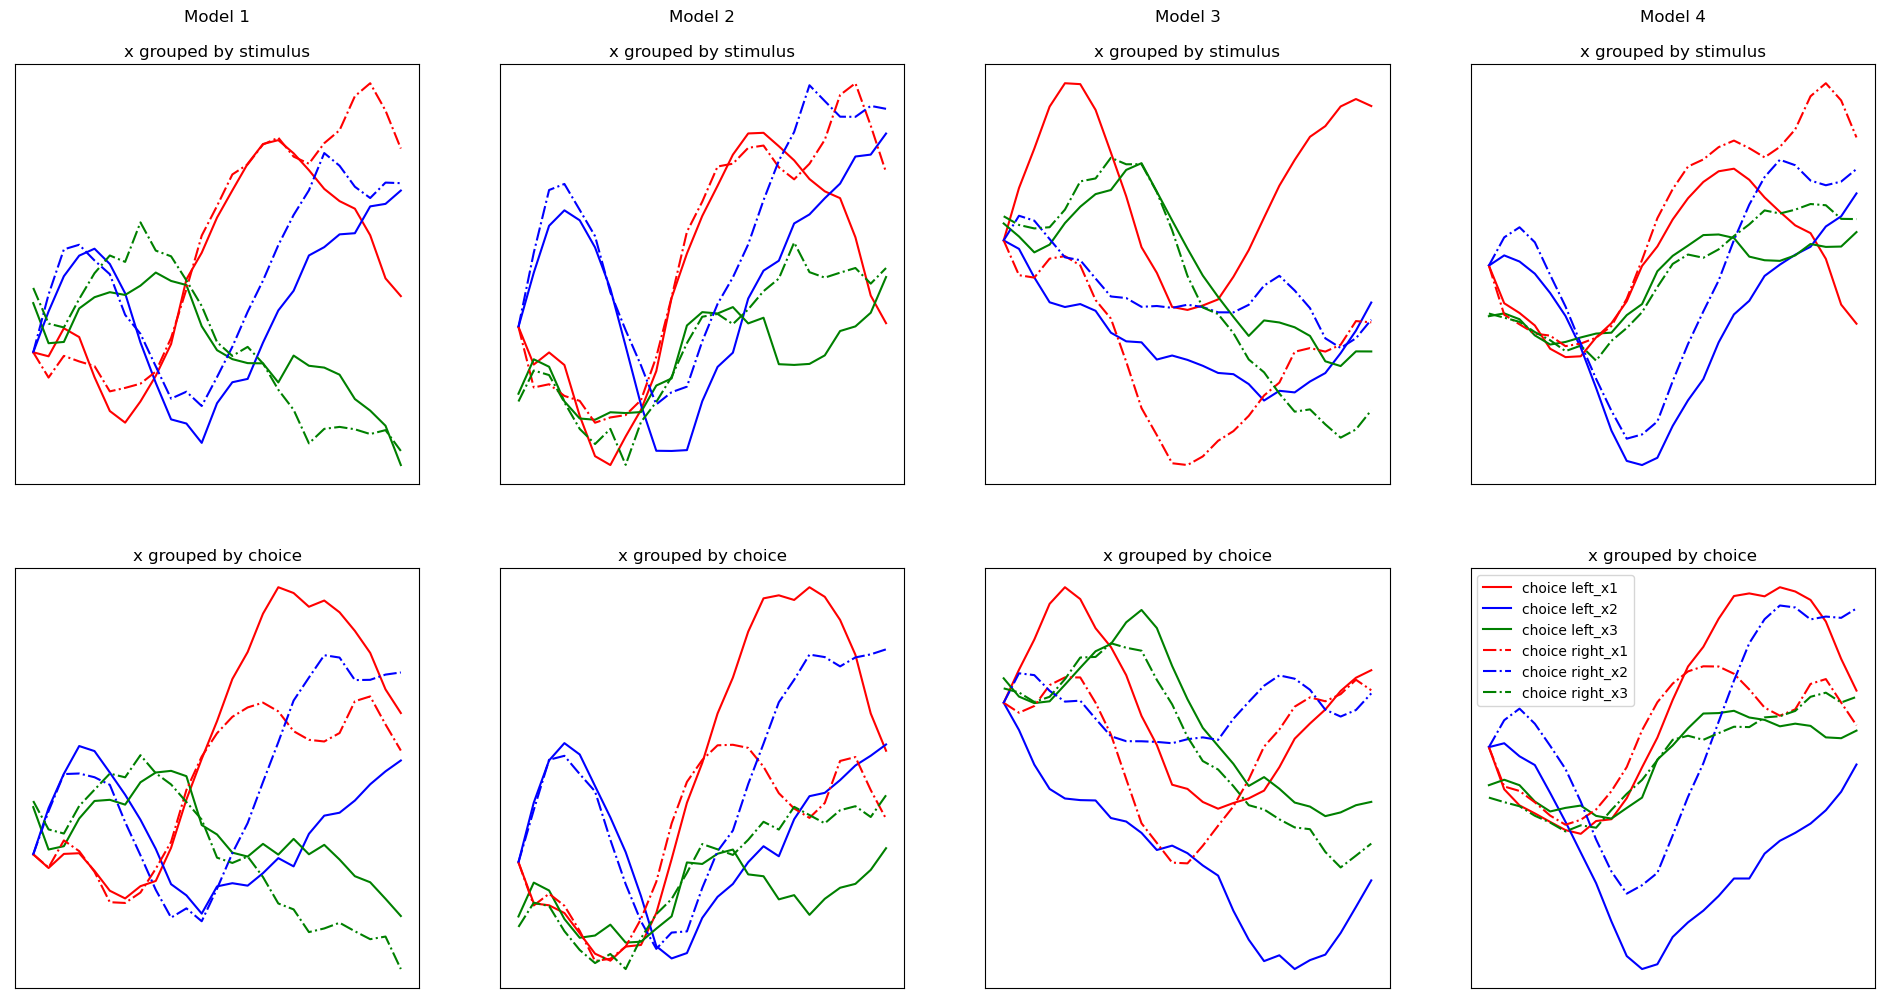

In [16]:
fig = plt.figure(figsize=(24, 12))
fig.tight_layout()
# gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
# plot_x(x_mu_all_1, behaviour_data, gs[0, 0], fig)
# plot_x(x_mu_all_2, behaviour_data, gs[0, 1], fig)
# plot_x(x_mu_all_3, behaviour_data, gs[1, 0], fig)
# plot_x(x_mu_all_4, behaviour_data, gs[1, 1], fig, ticks=True)
gs = fig.add_gridspec(1, 4, hspace=0.2, wspace=0.2)
plot_x(1, x_mu_all_1, behaviour_data, gs[0], fig)
plot_x(2, x_mu_all_2, behaviour_data, gs[1], fig)
plot_x(3, x_mu_all_3, behaviour_data, gs[2], fig)
plot_x(4, x_mu_all_4, behaviour_data, gs[3], fig, ticks=True)

In [17]:
def train_peak(z_mu_train, z_mu_test, x_mu_train, x_mu_test, behav):
    # pick bins around peak z
    # decoding_from = 'spikes' # spikes or mu
    decoding_from = 'mu' # spikes or mu
    # Thresholding based on z to keep only relevant time bins
    z_dim = z_mu_train.shape[-1]
    x_dim = x_mu_train.shape[-1]

    if behav == 'stim':
        y_train, y_test = y_stim_train, y_stim_test
    else:
        y_train, y_test = y_choice_train, y_choice_test
    

    # list_c = [0.1, 0.5, 1, 2, 5]
    list_c = [5]
    one_sided_window = 1
    # concatenate spikes with one sided window on both sides with zeros
    spikes_train_ = np.concatenate([np.zeros((len(spikes_train), one_sided_window, emissions_dim)), spikes_train, np.zeros((len(spikes_train), one_sided_window, emissions_dim))], axis=1)
    spikes_test_ = np.concatenate([np.zeros((len(spikes_test), one_sided_window, emissions_dim)), spikes_test, np.zeros((len(spikes_test), one_sided_window, emissions_dim))], axis=1)

    for i in range(z_dim):        
        # set spikes where z is not i to 0
        if decoding_from == 'spikes':
            x_train, x_test = spikes_train_.copy(), spikes_test_.copy()
        else:
            x_train = np.concatenate([np.zeros((len(x_mu_train), one_sided_window, x_dim)), x_mu_train, np.zeros((len(x_mu_train), one_sided_window, x_dim))], axis=1)
            x_test = np.concatenate([np.zeros((len(x_mu_test), one_sided_window, x_dim)), x_mu_test, np.zeros((len(x_mu_test), one_sided_window, x_dim))], axis=1)        
        # print(x_train.shape, x_test.shape)
        # find time bin where z peaks
        argmax_z_train = np.argmax(z_mu_train[:, :, i], axis=1)
        # print(argmax_z_train)
        argmax_z_test = np.argmax(z_mu_test[:, :, i], axis=1)    
        # take one sided window
        x_train = np.array([x[argmax_z_train[j]:argmax_z_train[j]+2*one_sided_window+1] for j, x in enumerate(x_train)]).reshape(x_train.shape[0], -1)
        x_test = np.array([x[argmax_z_test[j]:argmax_z_test[j]+2*one_sided_window+1] for j, x in enumerate(x_test)]).reshape(x_test.shape[0], -1)
        
        for c in list_c:
            # train svm        
            clf = SVC(C=c)
            # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
            clf.fit(x_train, y_train)
            # predict
            pred_test = clf.predict(x_test)
            pred_train = clf.predict(x_train)
            # calculate accuracy
            test_accuracy = round(accuracy_score(y_test, pred_test), 3)
            train_accuracy = round(accuracy_score(y_train, pred_train), 3)
            print("Decoding {} from z{}: C: {}, Train accuracy: {}, Test accuracy: {}".format(behav, i, c, train_accuracy, test_accuracy))        
    print("\n\n")

In [18]:
print('m1')
train_peak(z_train_1, z_test_1, x_mu_train_1, x_mu_test_1, 'stim')
train_peak(z_train_1, z_test_1, x_mu_train_1, x_mu_test_1, 'choice')

m1
Decoding stim from z0: C: 5, Train accuracy: 0.852, Test accuracy: 0.606
Decoding stim from z1: C: 5, Train accuracy: 0.836, Test accuracy: 0.606
Decoding stim from z2: C: 5, Train accuracy: 0.82, Test accuracy: 0.485



Decoding choice from z0: C: 5, Train accuracy: 0.859, Test accuracy: 0.515
Decoding choice from z1: C: 5, Train accuracy: 0.828, Test accuracy: 0.485
Decoding choice from z2: C: 5, Train accuracy: 0.82, Test accuracy: 0.545





In [19]:
print('m2')
train_peak(z_train_2, z_test_2, x_mu_train_2, x_mu_test_2,  'stim')
train_peak(z_train_2, z_test_2, x_mu_train_2, x_mu_test_2,  'choice')

m2
Decoding stim from z0: C: 5, Train accuracy: 0.852, Test accuracy: 0.364
Decoding stim from z1: C: 5, Train accuracy: 0.828, Test accuracy: 0.667
Decoding stim from z2: C: 5, Train accuracy: 0.805, Test accuracy: 0.455



Decoding choice from z0: C: 5, Train accuracy: 0.859, Test accuracy: 0.515
Decoding choice from z1: C: 5, Train accuracy: 0.875, Test accuracy: 0.545
Decoding choice from z2: C: 5, Train accuracy: 0.789, Test accuracy: 0.606





In [20]:
print('m3')
train_peak(z_train_3, z_test_3, x_mu_train_3, x_mu_test_3,  'stim')
train_peak(z_train_3, z_test_3, x_mu_train_3, x_mu_test_3,  'choice')

m3
Decoding stim from z0: C: 5, Train accuracy: 0.938, Test accuracy: 0.576
Decoding stim from z1: C: 5, Train accuracy: 0.93, Test accuracy: 0.515
Decoding stim from z2: C: 5, Train accuracy: 0.859, Test accuracy: 0.394



Decoding choice from z0: C: 5, Train accuracy: 0.883, Test accuracy: 0.727
Decoding choice from z1: C: 5, Train accuracy: 0.922, Test accuracy: 0.788
Decoding choice from z2: C: 5, Train accuracy: 0.867, Test accuracy: 0.697





In [21]:
print('m4')
train_peak(z_train_4, z_test_4, x_mu_train_4, x_mu_test_4,  'stim')
train_peak(z_train_4, z_test_4, x_mu_train_4, x_mu_test_4,  'choice')

m4
Decoding stim from z0: C: 5, Train accuracy: 0.852, Test accuracy: 0.515
Decoding stim from z1: C: 5, Train accuracy: 0.859, Test accuracy: 0.758
Decoding stim from z2: C: 5, Train accuracy: 0.828, Test accuracy: 0.606



Decoding choice from z0: C: 5, Train accuracy: 0.852, Test accuracy: 0.515
Decoding choice from z1: C: 5, Train accuracy: 0.977, Test accuracy: 0.788
Decoding choice from z2: C: 5, Train accuracy: 0.812, Test accuracy: 0.545





# Single-trial

In [52]:
def plot_single(model_id, trial_idx, x, z, contacts, behavior_data, gs_obj, fig):
    # plot a random trial
    stim, choice = behaviour_data[:, 0], behaviour_data[:, 1]
    
    gssub = gs_obj.subgridspec(3, 1)
    ax1 = fig.add_subplot(gssub[0])
    ax2 = fig.add_subplot(gssub[1])
    ax3 = fig.add_subplot(gssub[2])
    axs = [ax1, ax2, ax3]
        
    axs[0].plot(t, z[trial_idx, :, 0], label='z1', marker='o', color=colors[0])
    axs[0].plot(t, z[trial_idx, :, 1], label='z2', marker='o', color=colors[1])
    axs[0].plot(t, z[trial_idx, :, 2], label='z3', marker='o', color=colors[2])
    axs[0].set_title('Model {}'.format(model_id+1))
    # axs[0].set_ylim(0, 1)
    axs[0].set_ylabel('z')
    axs[0].legend()
    axs[0].set_xticks([])
    # plot num contacts
    axs[1].plot(t, num_contacts[trial_idx], marker='o', label='num contacts')
    # axs[1].set_title('num contacts and amplitude of whisk')
    axs[1].set_xticks([])
    axs[1].set_ylabel('Num contacts')
    axs[1].legend(loc='upper left')
    # plot x
    axs[2].plot(t, x[trial_idx, :, 0], label='x0', marker='o', color=colors[0])
    axs[2].plot(t, x[trial_idx, :, 1], label='x1', marker='o', color=colors[1])
    axs[2].plot(t, x[trial_idx, :, 2], label='x2', marker='o', color=colors[2])    
    axs[2].set_title('x, stimulus: {}, choice: {}'.format(stim[trial_idx].astype(int), choice[trial_idx].astype(int)))

In [53]:
# trial_idx = np.random.randint(len(z_all_1))
trial_idx = 69

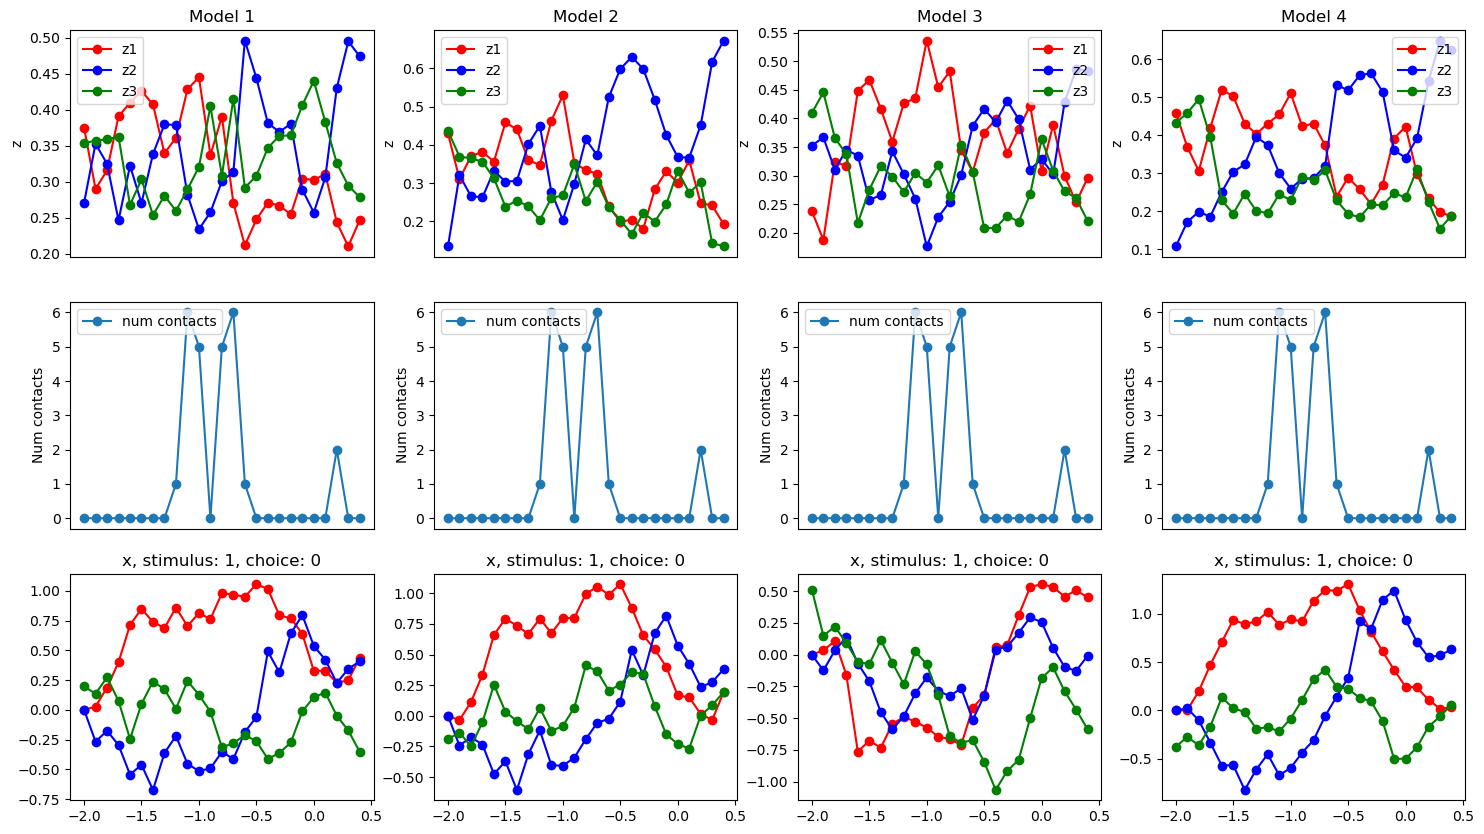

In [54]:
# fig = plt.figure(figsize=(12, 18))
# fig.tight_layout()
# gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.2)
# plot_single(trial_idx, x_mu_all_1, z_all_1, num_contacts, behaviour_data, gs[0, 0], fig)
# plot_single(trial_idx, x_mu_all_2, z_all_2, num_contacts, behaviour_data, gs[0, 1], fig)
# plot_single(trial_idx, x_mu_all_3, z_all_3, num_contacts, behaviour_data, gs[1, 0], fig)
# plot_single(trial_idx, x_mu_all_4, z_all_4, num_contacts, behaviour_data, gs[1, 1], fig)

fig = plt.figure(figsize=(18, 10))
fig.tight_layout()
gs = fig.add_gridspec(1, 4, hspace=0.2, wspace=0.2)
plot_single(0, trial_idx, x_mu_all_1, z_all_1, num_contacts, behaviour_data, gs[0], fig)
plot_single(1, trial_idx, x_mu_all_2, z_all_2, num_contacts, behaviour_data, gs[1], fig)
plot_single(2, trial_idx, x_mu_all_3, z_all_3, num_contacts, behaviour_data, gs[2], fig)
plot_single(3, trial_idx, x_mu_all_4, z_all_4, num_contacts, behaviour_data, gs[3], fig)